In [1]:
from basicgeo import P2, P3
from wingshape import WingShape
from parapolygraph import ParamPolyGraph
import numpy, math

wingshape = WingShape("P7-211221-XYZ geometry.csv")        
print("Parametrization in uv: ", wingshape.urange, wingshape.vrange)
# approximately flat and in metres (based around section 7) without the compression at the leading edge    
#parapolygraph = ParamPolyGraph(wingshape, "segmentedwing.txt", deprecatedTrimFile=True)
#parapolygraph.saveas("test.json")
parapolygraph = ParamPolyGraph(wingshape, "test.json")


Parametrization in uv:  (0, 6.11206792886613) (-1.377293405726668, 1.377293405726668)


<IPython.core.display.Javascript object>


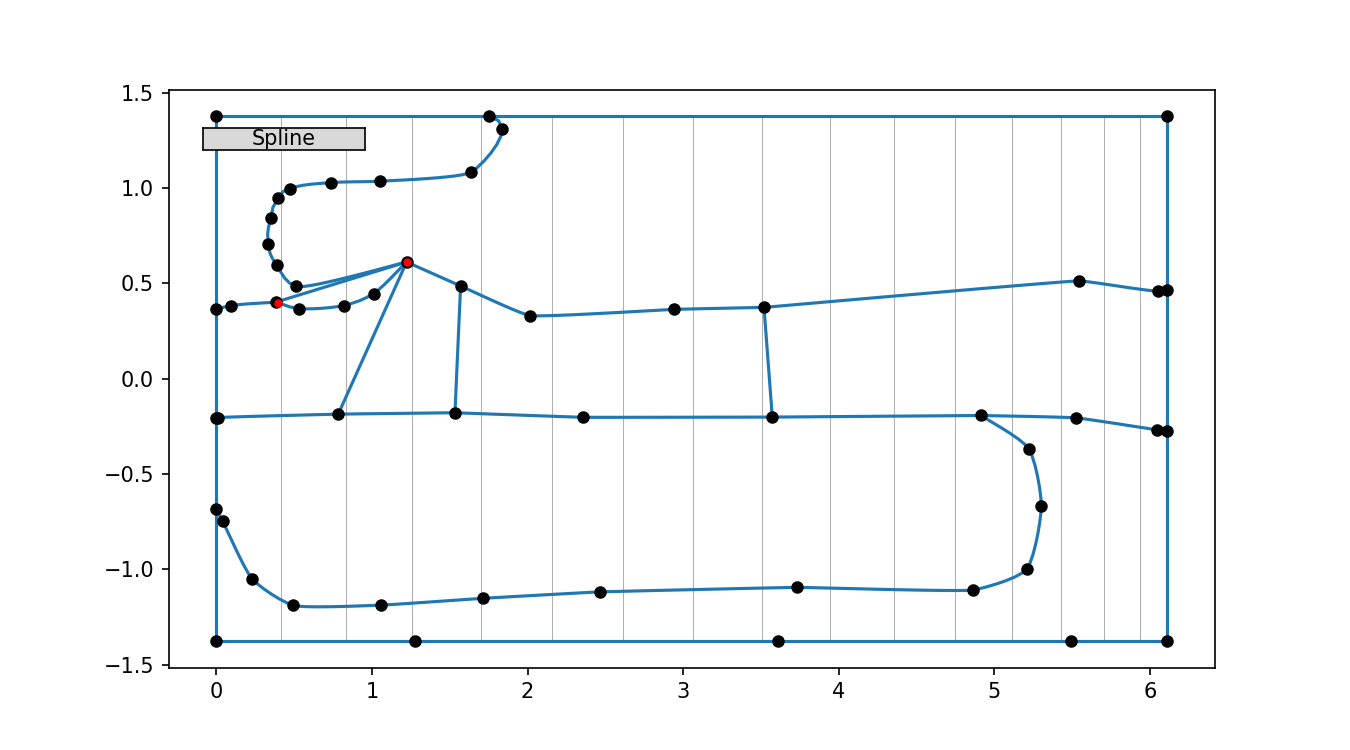

In [2]:
%matplotlib notebook

from matplotlib import pyplot as plt
import interactiveuvpara

fig = plt.figure(figsize=(9,5))
interactiveuvpara.makeinteractivefigure(fig, parapolygraph)
plt.show()

In [3]:
parapolygraph.saveas("test.json")


In [8]:
interactiveuvpara.events[-1].__dict__


{'button': <MouseButton.LEFT: 1>,
 'key': 'alt',
 'step': 0,
 'dblclick': False,
 'name': 'button_release_event',
 'canvas': <matplotlib.backends.backend_nbagg.FigureCanvasNbAgg at 0x7f44f53c7fa0>,
 'guiEvent': {'isTrusted': True},
 'x': 262,
 'y': 614,
 'inaxes': <Axes:>,
 'xdata': 0.370987644901982,
 'ydata': 0.6444447835286446}